In [1]:
SUBJECT = 1
BASE_DIR = "/tmp/akshett.jindal"
MODEL_ID = "llava-hf/llava-1.5-13b-hf"
CREATE_TEST_IMAGES = False

In [2]:
MODEL_NAME = MODEL_ID.replace("/", "_").replace(" ", "_")

In [3]:
import os

EXP_DESIGN_FPATH = os.path.join(BASE_DIR, "nsd_expdesign.mat")

In [20]:
OUTPUT_DIR = os.path.join(BASE_DIR, "trained_models", MODEL_NAME, f"subject_{SUBJECT:02}")

In [5]:
import glob

IMAGE_EMBEDDINGS_DIR = os.path.join(
    BASE_DIR,
    "image_embeddings",
    MODEL_NAME,
    f"subject_{SUBJECT:02}",
    "batch_*.pkl",
)

batch_paths = sorted(
    glob.glob(IMAGE_EMBEDDINGS_DIR, recursive=True),
    key=lambda i: int(i.split('_')[-1].split('.')[0]),
)

In [6]:
import pickle
from tqdm.auto import tqdm

HIDDEN_STATES = {}
HIDDEN_LAYERS_COUNT = 0

batch_files_iter = tqdm(
    batch_paths,
    total=len(batch_paths),
    desc="Batch File",
    position=0,
)

for batch_filepath in batch_files_iter:

    with open(batch_filepath, "rb") as batch_file:
        batches = pickle.load(batch_file)

    for batch in batches:
        hidden_states = batch['hidden_states']

        for image_num, image_id in enumerate(batch["image_ids"]):
            hs = tuple(hs[image_num] for hs in hidden_states)

            HIDDEN_LAYERS_COUNT = len(hs)
            HIDDEN_STATES[image_id] = hs

    del batches

Batch File:   0%|          | 0/50 [00:00<?, ?it/s]

In [7]:
HIDDEN_LAYERS_COUNT

41

In [8]:
min(HIDDEN_STATES.keys()), max(HIDDEN_STATES.keys())

(14, 73000)

In [9]:
from nsd_dataset import mind_eye_nsd_utils as menutils

(
    trial_order,
    session_data,
    (
        trn_stim_ordering, trn_voxel_data,
        val_stim_ordering, val_voxel_data
    )
) = menutils.get_split_data(BASE_DIR, SUBJECT, average_out_fmri=True)

Total number of voxels = 15724


In [10]:
print(f"{trial_order.shape = }, {trial_order.min() = }, {trial_order.max() = }")
print(f"{session_data.shape = }, {session_data.min() = }, {session_data.max() = }")
print(f"{trn_stim_ordering.shape = }, {trn_stim_ordering.min() = }, {trn_stim_ordering.max() = }")
print(f"{trn_voxel_data.shape = }, {trn_voxel_data.min() = }, {trn_voxel_data.max() = }")
print(f"{val_stim_ordering.shape = }, {val_stim_ordering.min() = }, {val_stim_ordering.max() = }")
print(f"{val_voxel_data.shape = }, {val_voxel_data.min() = }, {val_voxel_data.max() = }")

trial_order.shape = (10000,), trial_order.min() = 1, trial_order.max() = 10000
session_data.shape = (10000, 15724), session_data.min() = -32768.0, session_data.max() = 32767.0
trn_stim_ordering.shape = (9000,), trn_stim_ordering.min() = 1000, trn_stim_ordering.max() = 9999
trn_voxel_data.shape = (9000, 15724), trn_voxel_data.min() = -32768.0, trn_voxel_data.max() = 32767.0
val_stim_ordering.shape = (1000,), val_stim_ordering.min() = 0, val_stim_ordering.max() = 999
val_voxel_data.shape = (1000, 15724), val_voxel_data.min() = -28514.333333333332, val_voxel_data.max() = 32767.0


In [11]:
if CREATE_TEST_IMAGES:
    import numpy as np

    np.random.seed(42)

    tst_indices = np.random.choice(
        np.arange(trn_stim_ordering.shape[0]),
        size=val_stim_ordering.shape[0],
        replace=False,
    )

    tst_indices.shape, tst_indices.min(), tst_indices.max()

In [12]:
if CREATE_TEST_IMAGES:
    trn_mask = np.ones(trn_stim_ordering.shape[0], dtype=bool)
    trn_mask[tst_indices] = False

    train_stim_ordering = np.copy(trn_stim_ordering[trn_mask])
    train_voxel_data = np.copy(trn_voxel_data[trn_mask])

    tst_stim_ordering = np.copy(trn_stim_ordering[tst_indices])
    tst_voxel_data = np.copy(trn_voxel_data[tst_indices])

    del trn_stim_ordering, trn_voxel_data

    trn_stim_ordering = train_stim_ordering
    trn_voxel_data = train_voxel_data

In [13]:
print(f"{session_data.shape = }")
print(f"{trn_stim_ordering.shape = }")
print(f"{trn_voxel_data.shape = }")
if CREATE_TEST_IMAGES:
    print(f"{tst_stim_ordering.shape = }")
    print(f"{tst_voxel_data.shape = }")
print(f"{val_stim_ordering.shape = }")
print(f"{val_voxel_data.shape = }")

session_data.shape = (10000, 15724)
trn_stim_ordering.shape = (9000,)
trn_voxel_data.shape = (9000, 15724)
val_stim_ordering.shape = (1000,)
val_voxel_data.shape = (1000, 15724)


In [14]:
exp_design = menutils.load_exp_design_file(BASE_DIR)

trial_images = exp_design["subjectim"]

In [15]:
trn_images = trial_images[SUBJECT-1, trn_stim_ordering] - 1
val_images = trial_images[SUBJECT-1, val_stim_ordering] - 1
if CREATE_TEST_IMAGES:
    tst_images = trial_images[SUBJECT-1, tst_stim_ordering] - 1

trn_images.shape, trn_images.min(), trn_images.max()

((9000,), 13, 72999)

In [16]:
from himalaya.backend import set_backend

backend = set_backend("torch_cuda", on_error="warn")
backend

<module 'himalaya.backend.torch_cuda' from '/home2/akshett.jindal/miniconda3/envs/subba/lib/python3.10/site-packages/himalaya/backend/torch_cuda.py'>

In [17]:
import numpy as np

alphas = np.logspace(1, 4, 25)
alphas

array([   10.        ,    13.33521432,    17.7827941 ,    23.71373706,
          31.6227766 ,    42.16965034,    56.23413252,    74.98942093,
         100.        ,   133.35214322,   177.827941  ,   237.13737057,
         316.22776602,   421.69650343,   562.34132519,   749.89420933,
        1000.        ,  1333.52143216,  1778.27941004,  2371.37370566,
        3162.27766017,  4216.96503429,  5623.4132519 ,  7498.94209332,
       10000.        ])

In [18]:
from himalaya.ridge import RidgeCV
import numpy as np
from sklearn.pipeline import make_pipeline

MODELS = []

for layer_num in tqdm(range(HIDDEN_LAYERS_COUNT)):
    trn_hs = np.array([
        HIDDEN_STATES[image_id+1][layer_num]
        for image_id in trn_images
    ])
    val_hs = np.array([
        HIDDEN_STATES[image_id+1][layer_num]
        for image_id in val_images
    ])

    kernel_ridge_cv = RidgeCV(
        alphas=alphas,
        solver_params=dict(
            n_targets_batch=500,
            n_alphas_batch=10,
            n_targets_batch_refit=100,
        )
    )
    pipeline = make_pipeline(kernel_ridge_cv)
    _ = pipeline.fit(trn_hs, trn_voxel_data)

    trn_scores = backend.to_numpy(pipeline.score(trn_hs, trn_voxel_data))
    val_scores = backend.to_numpy(pipeline.score(val_hs, val_voxel_data))

    # print(f"[{layer_num+1:02}/{HIDDEN_LAYERS_COUNT:02}] {trn_score = }, {val_score = }")

    MODELS.append({
        "model": pipeline,
        "trn_scores": trn_scores,
        "val_scores": val_scores,
    })

  0%|          | 0/41 [00:00<?, ?it/s]

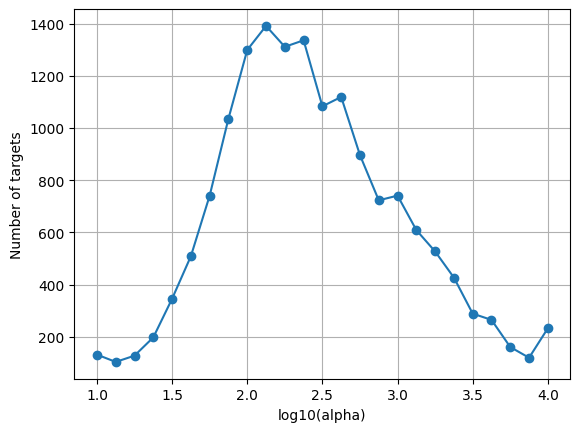

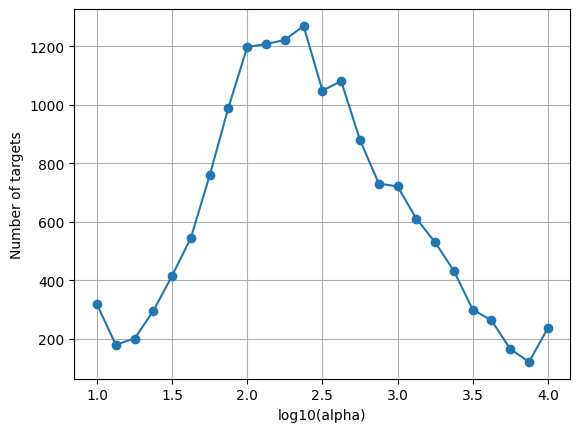

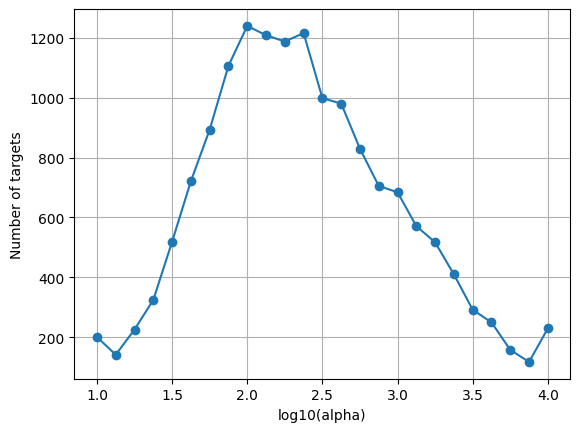

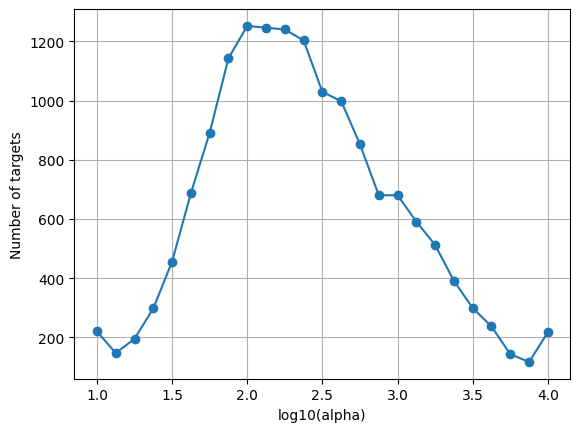

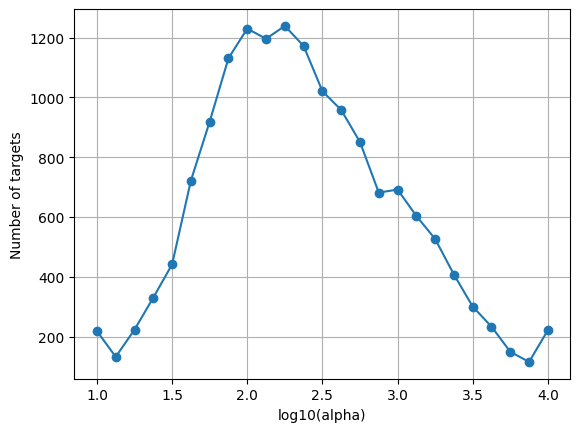

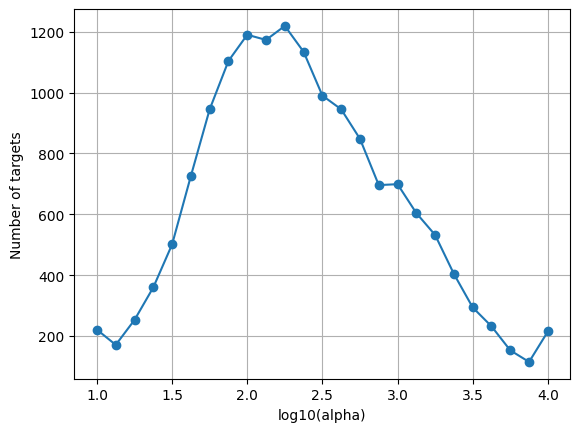

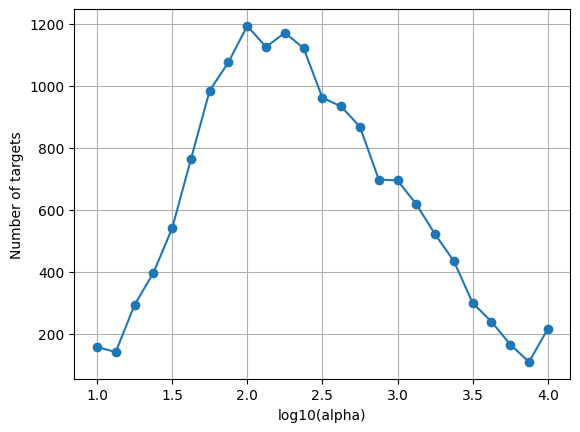

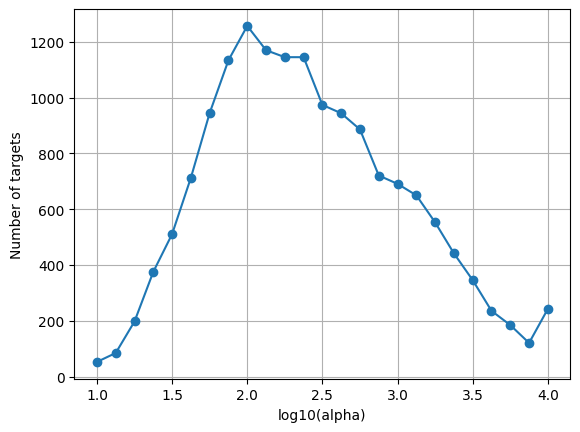

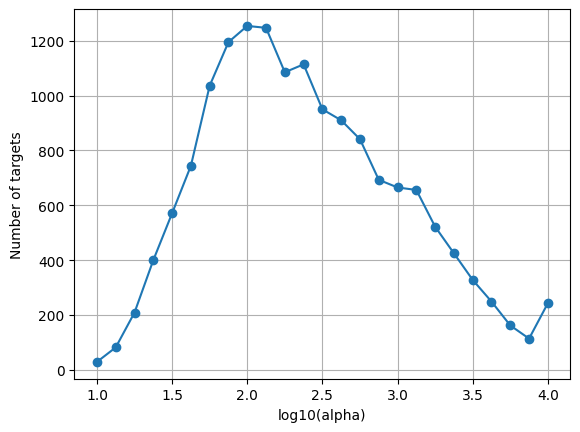

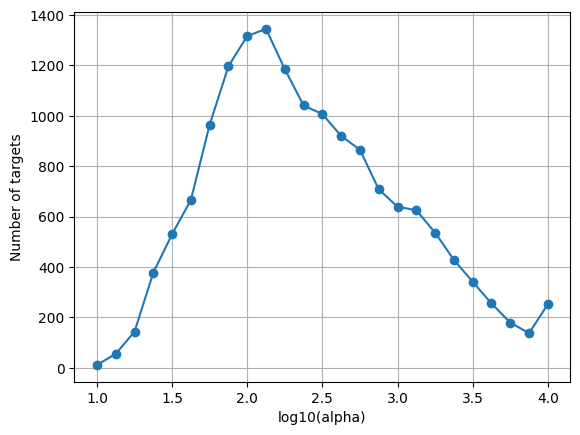

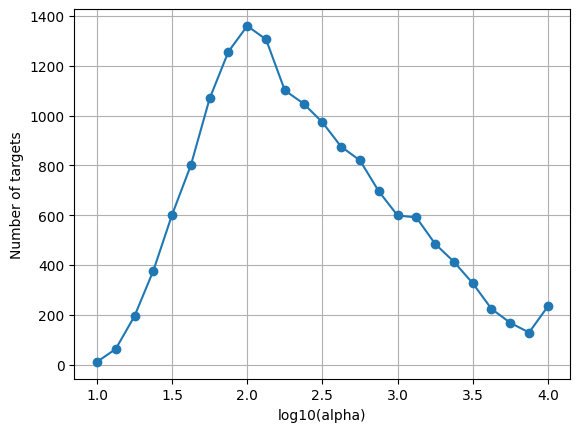

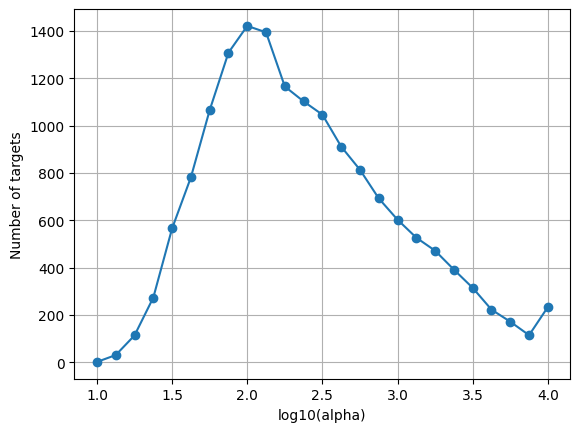

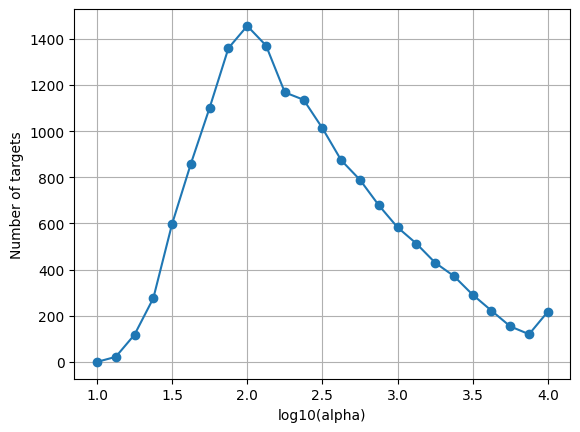

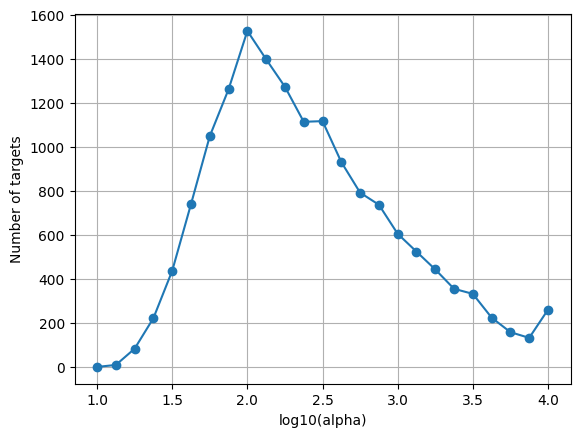

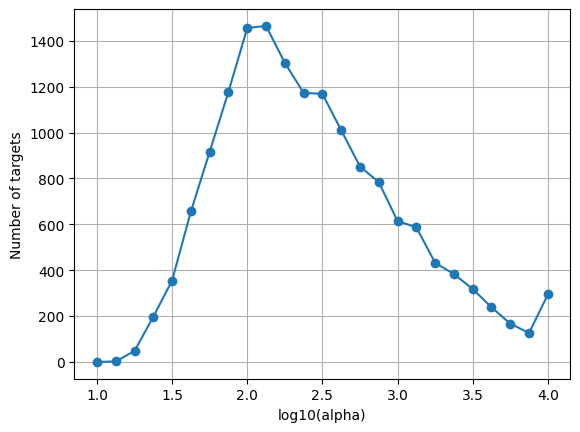

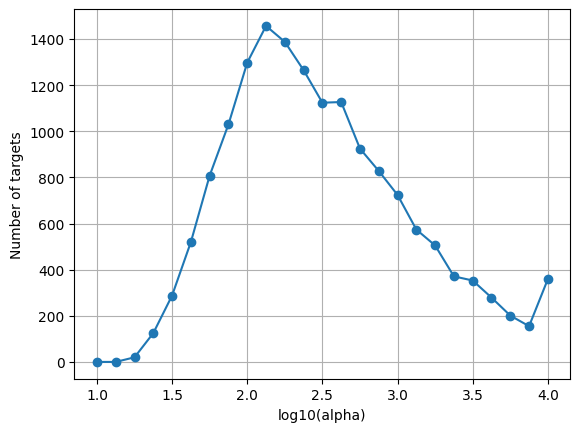

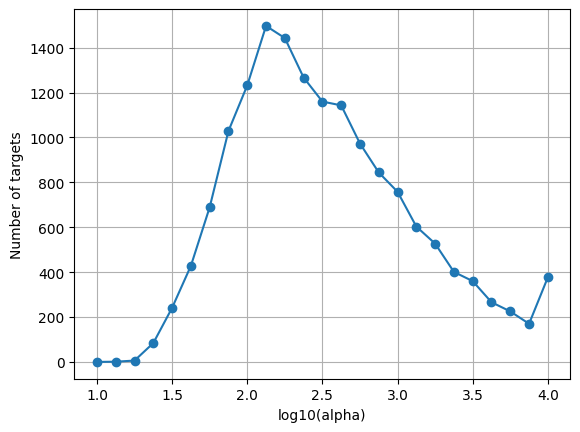

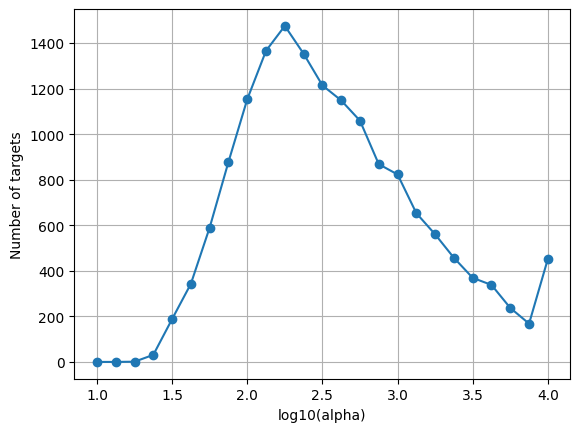

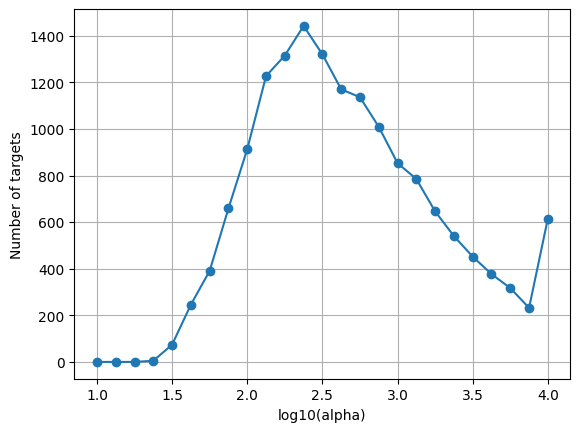

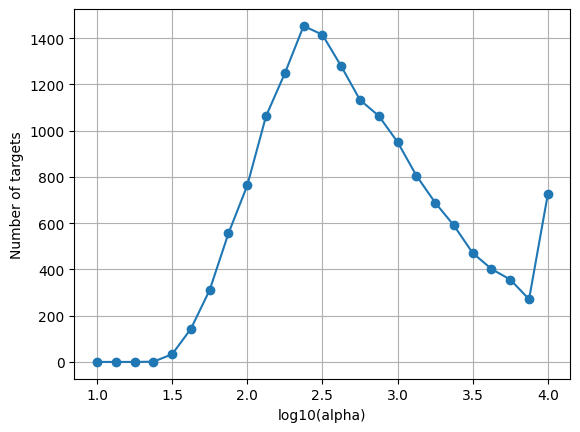

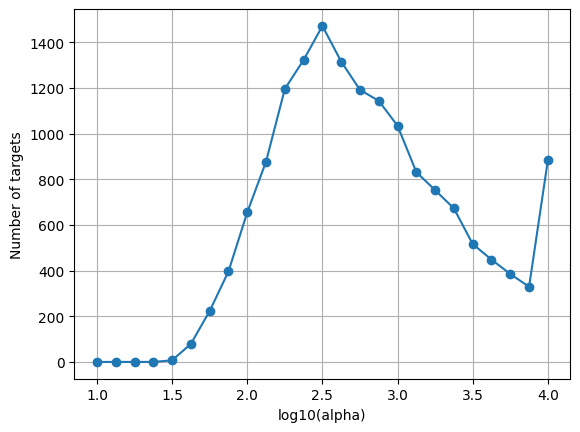

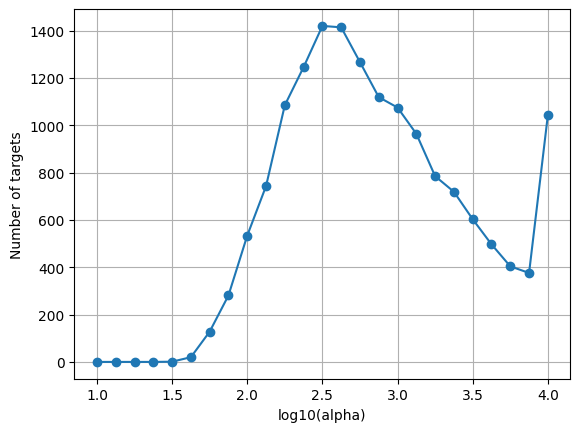

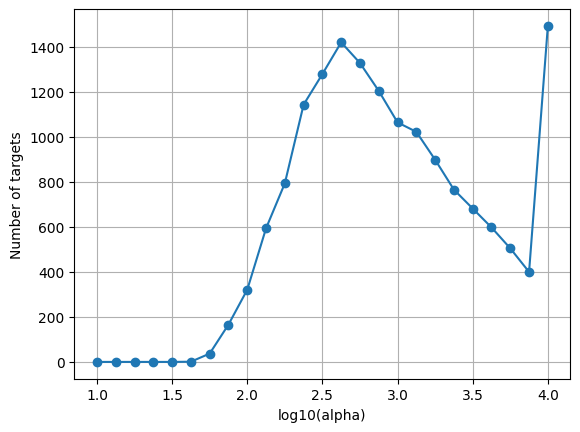

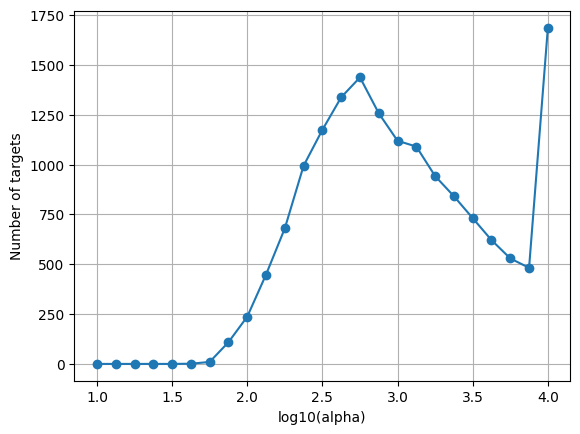

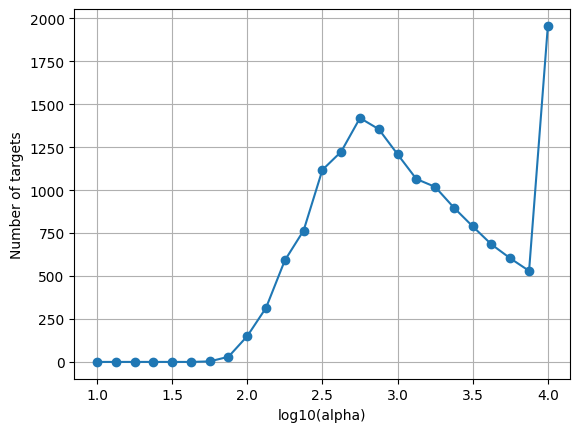

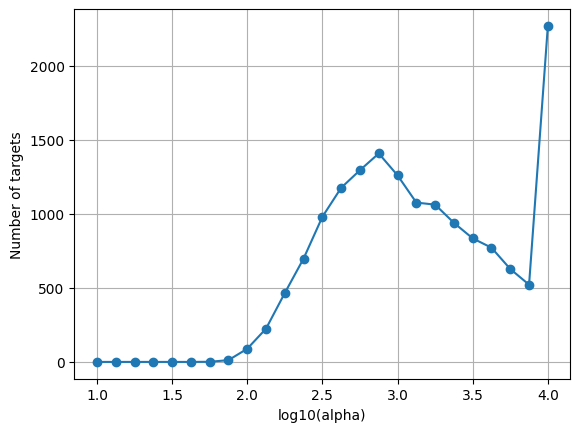

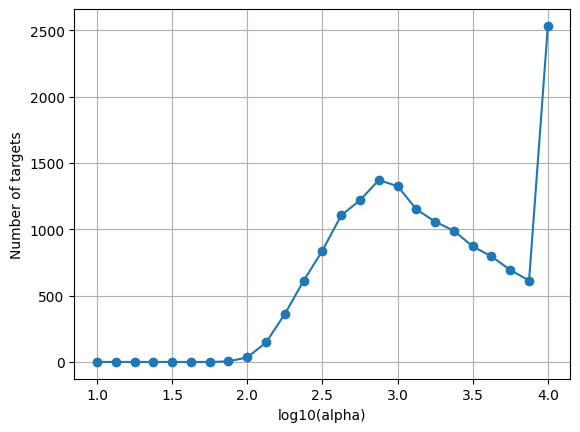

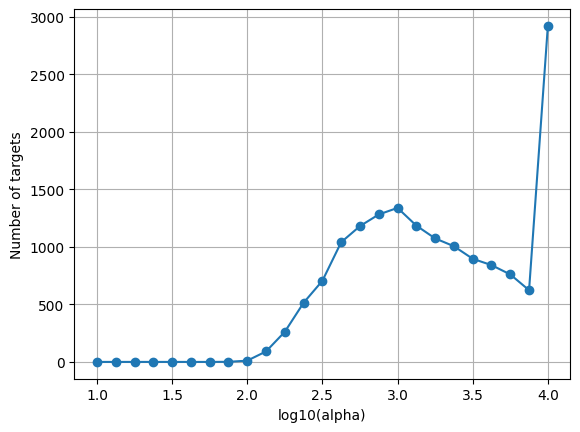

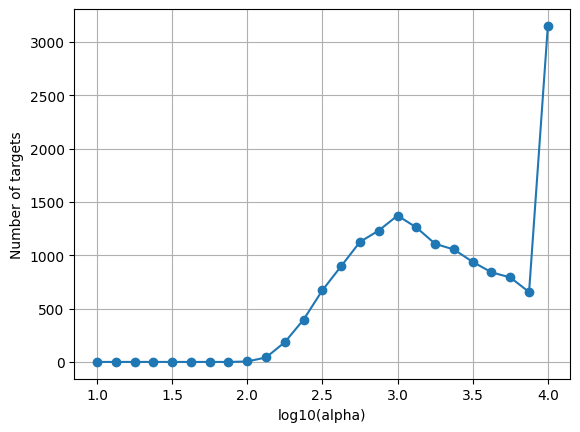

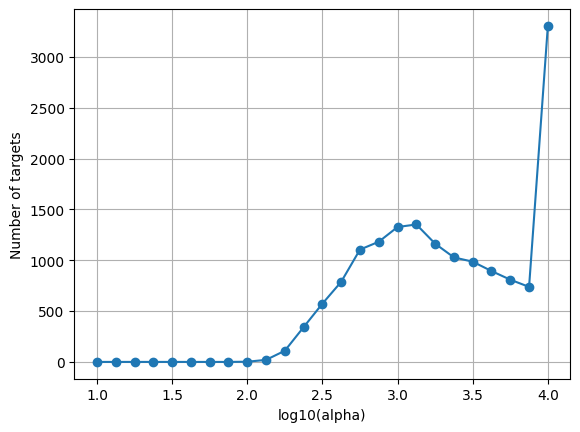

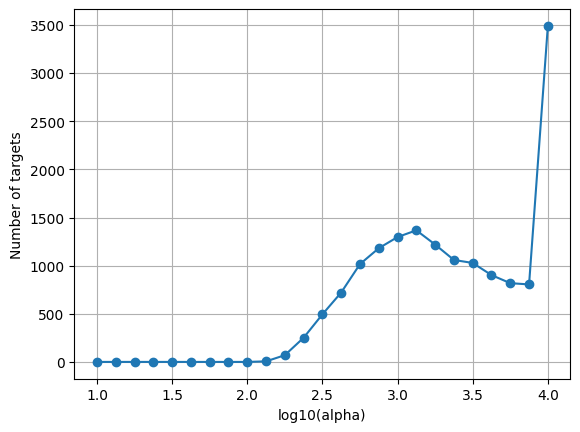

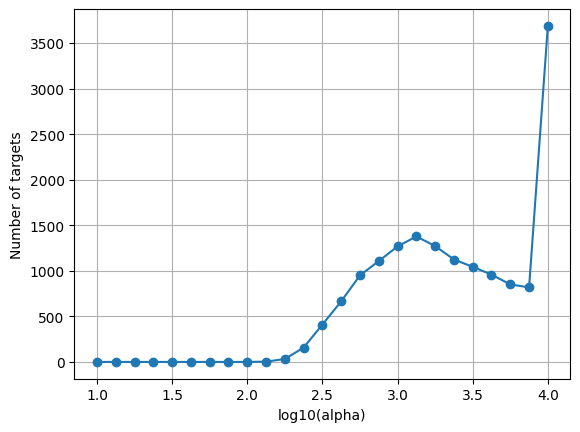

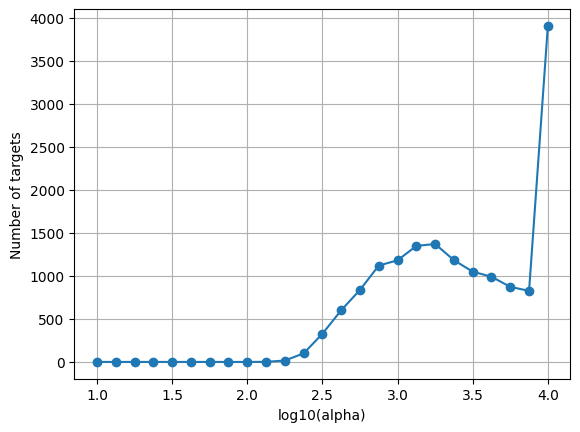

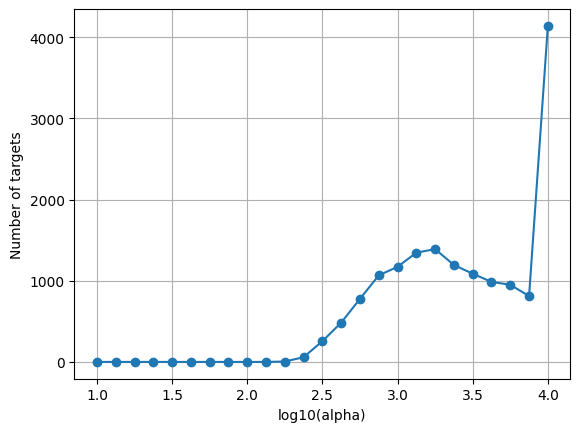

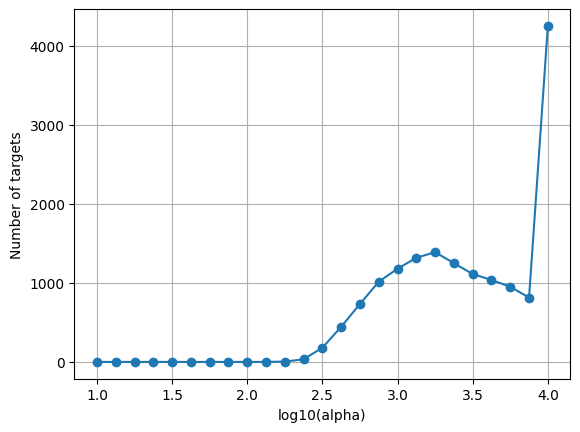

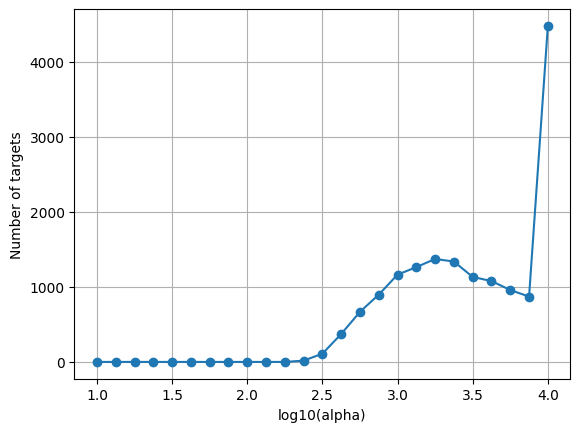

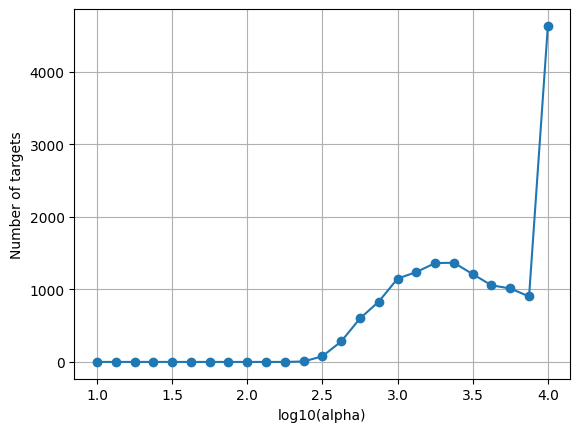

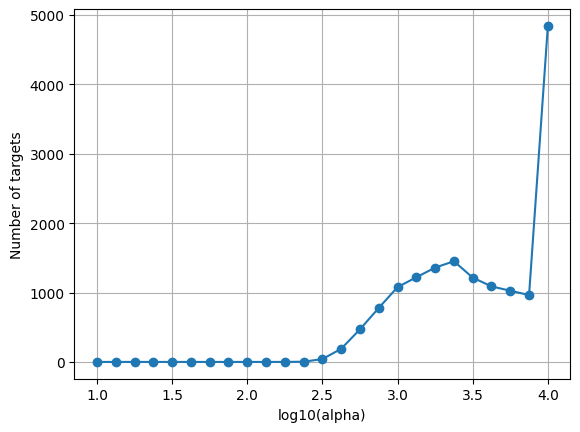

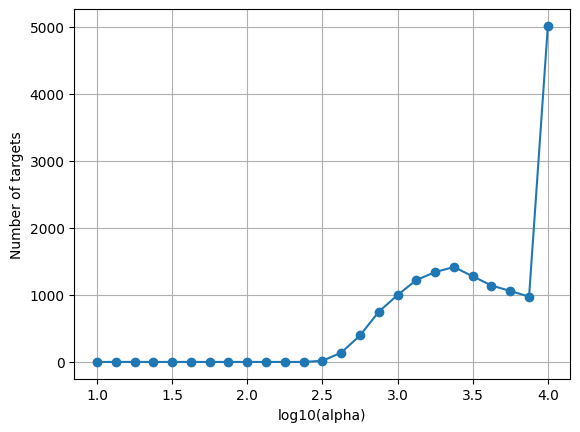

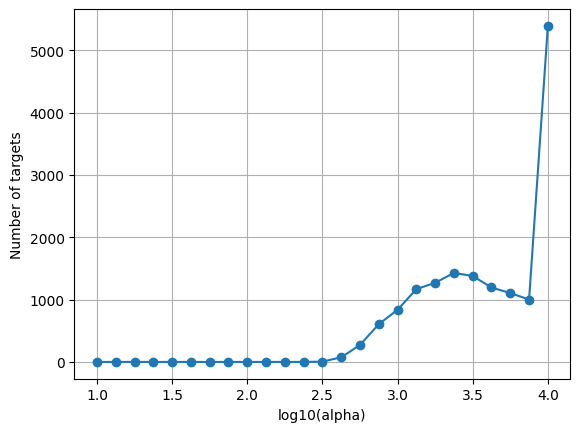

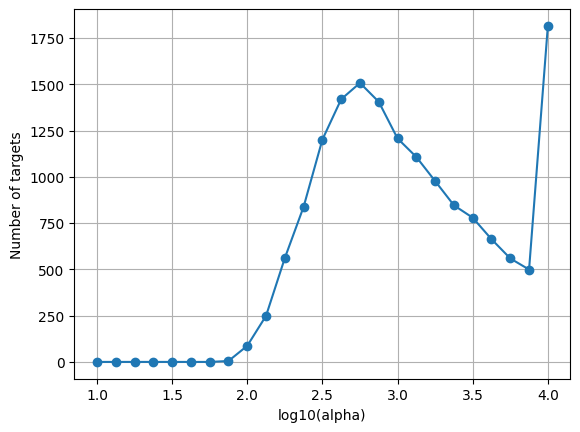

In [24]:
from himalaya.viz import plot_alphas_diagnostic
from matplotlib import pyplot as plt
import os
from os import path
import pickle

image_output_dir = path.join(OUTPUT_DIR, "best_alphas")
model_output_dir = path.join(OUTPUT_DIR, "models")

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(image_output_dir, exist_ok=True)
os.makedirs(model_output_dir, exist_ok=True)

for model_num, model in enumerate(MODELS):
    pipeline = model["model"]
    best_alphas = backend.to_numpy(pipeline[-1].best_alphas_)
    plot_alphas_diagnostic(best_alphas=best_alphas, alphas=alphas)
    plt.savefig(path.join(OUTPUT_DIR, "best_alphas", f"layer_{model_num+1:02}.png"))
    plt.show()

    with open(path.join(OUTPUT_DIR, "models", f"layer_{model_num+1:02}.pkl"), "wb") as f:
        pickle.dump(model, f)

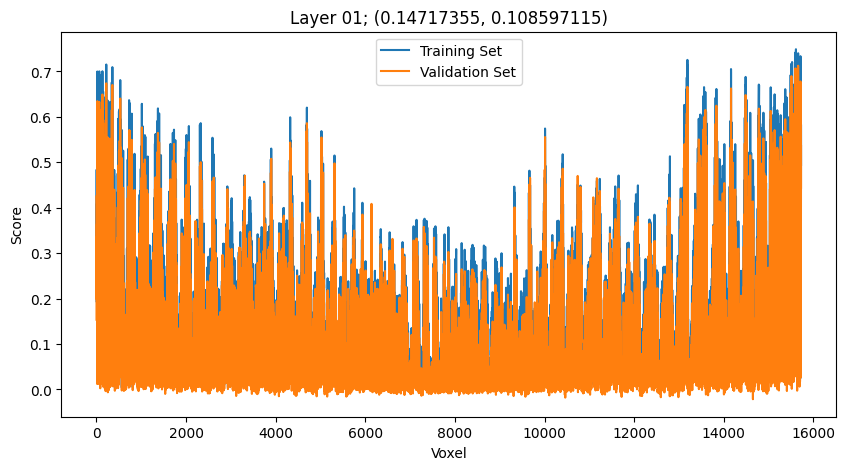

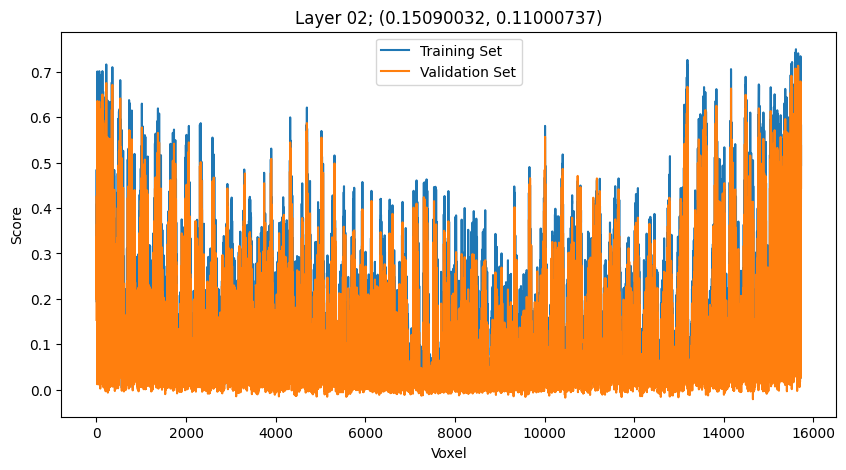

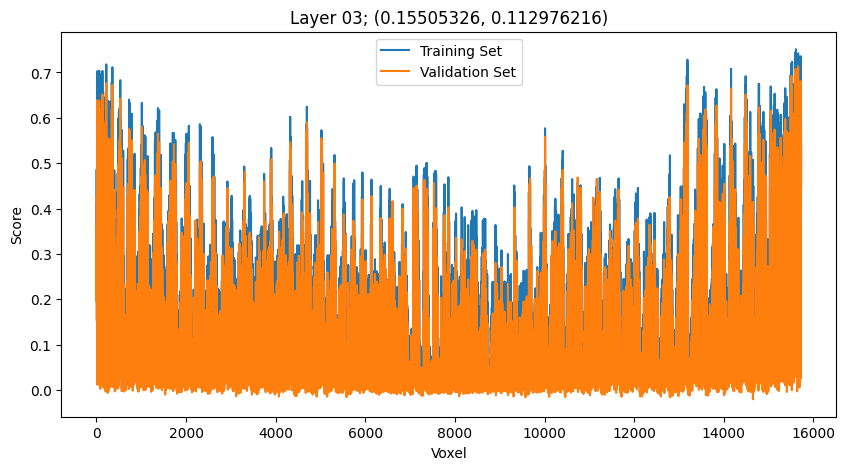

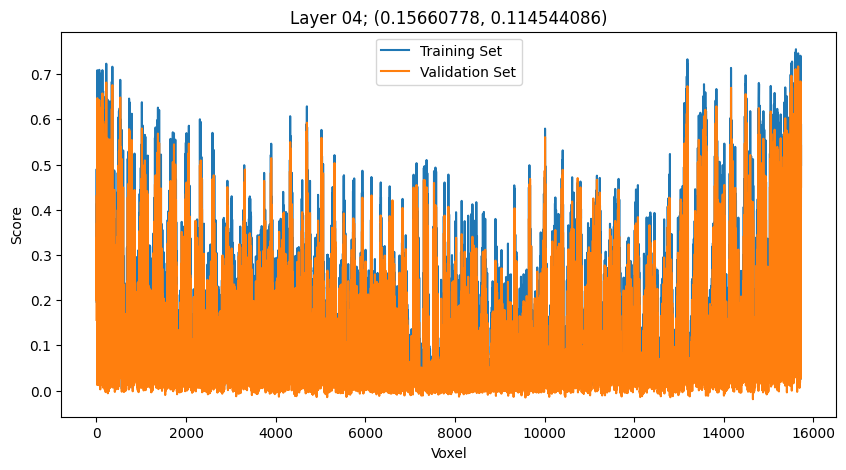

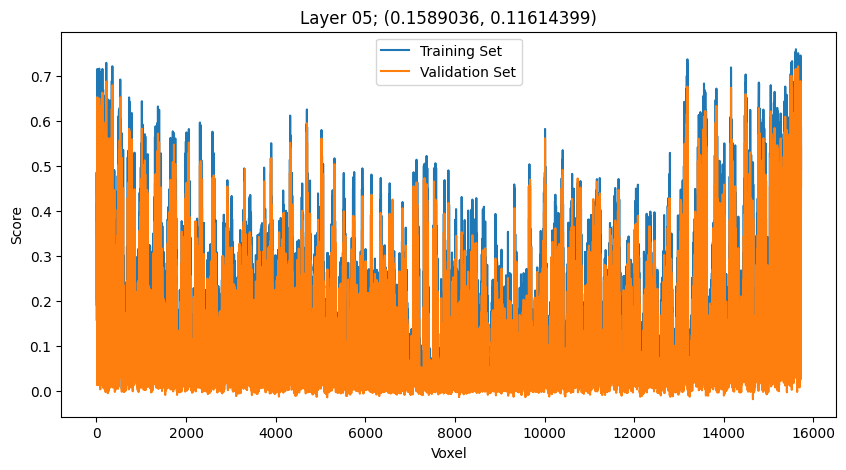

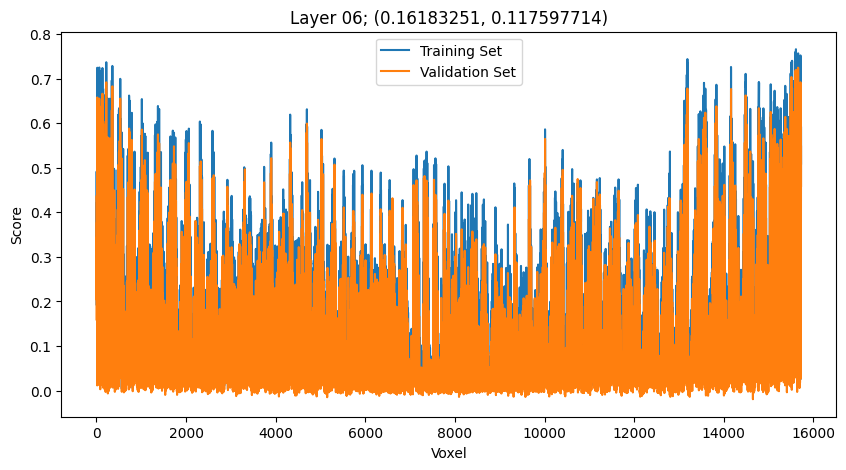

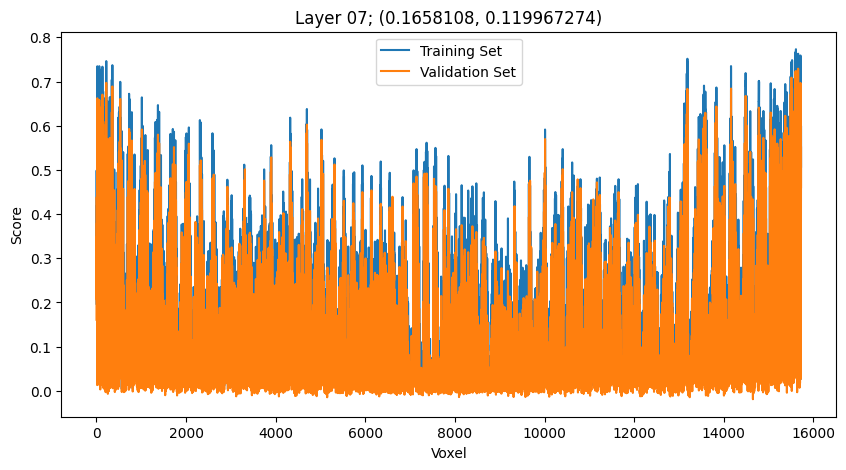

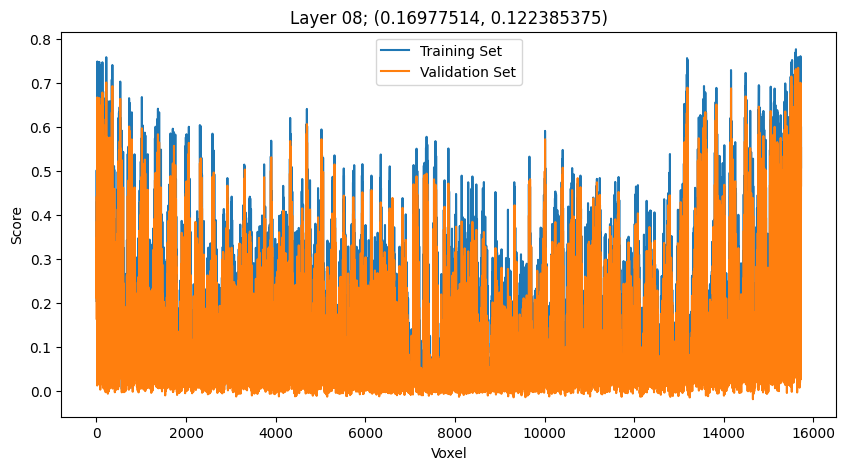

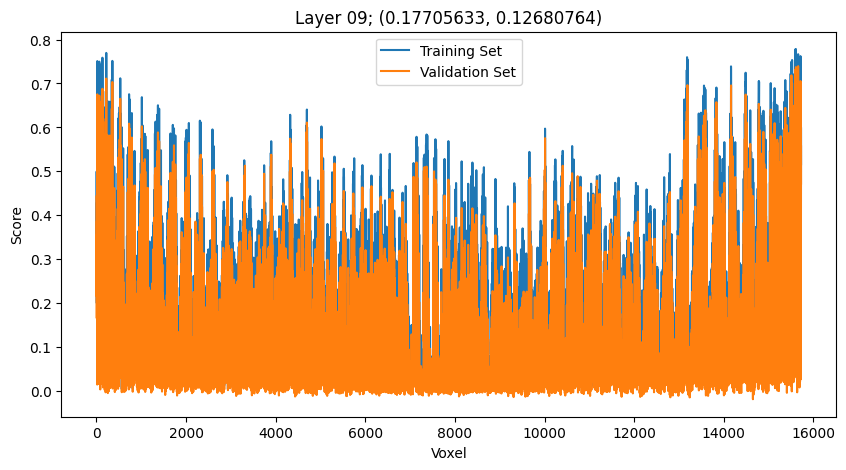

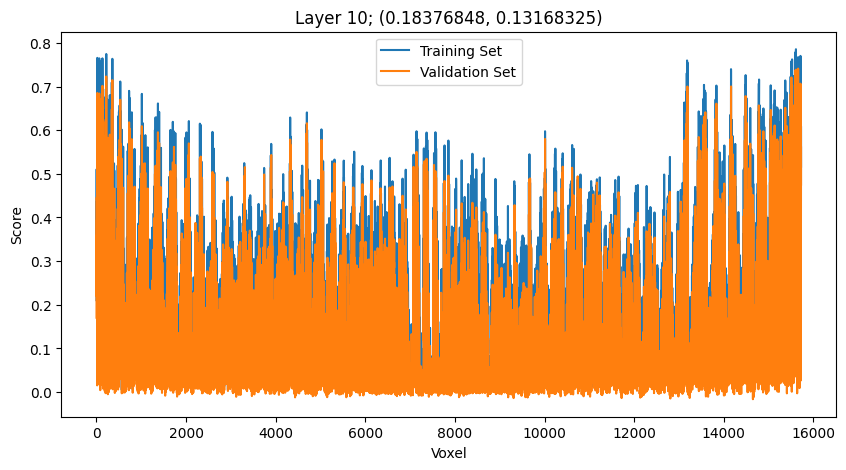

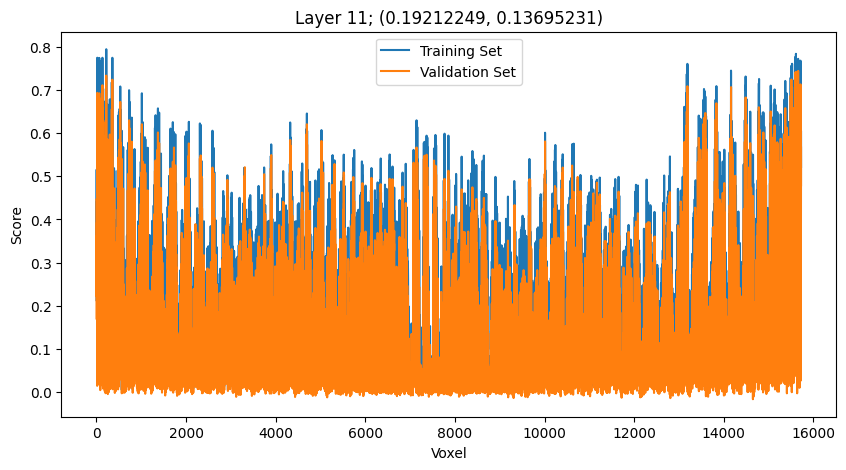

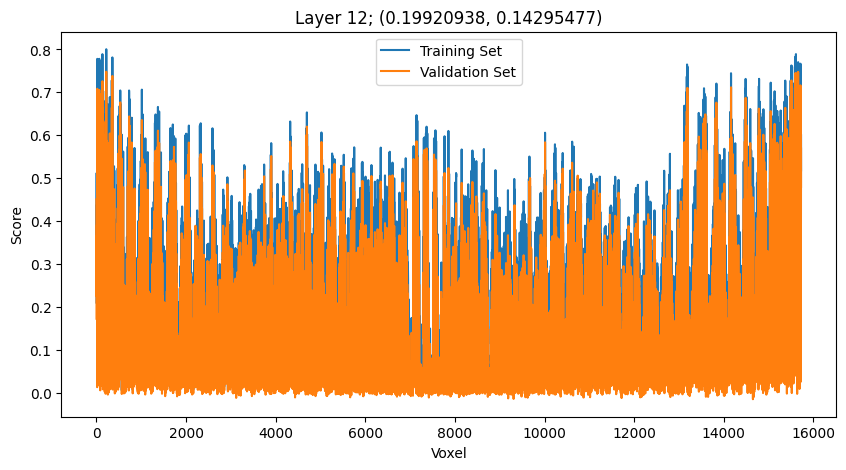

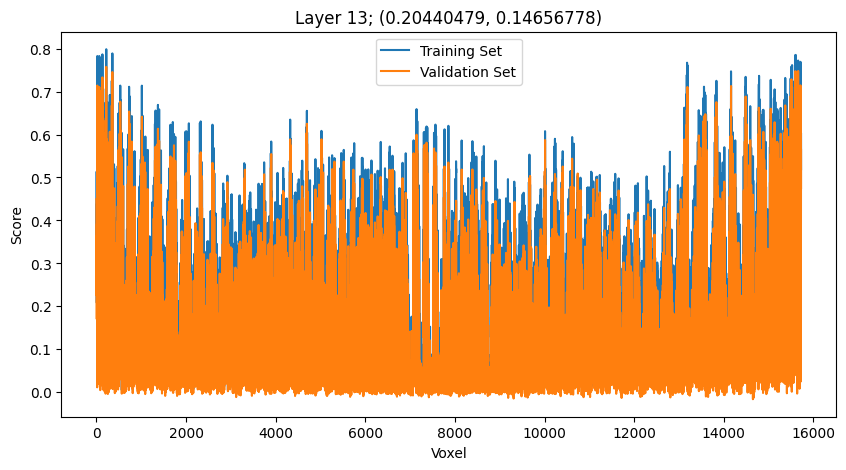

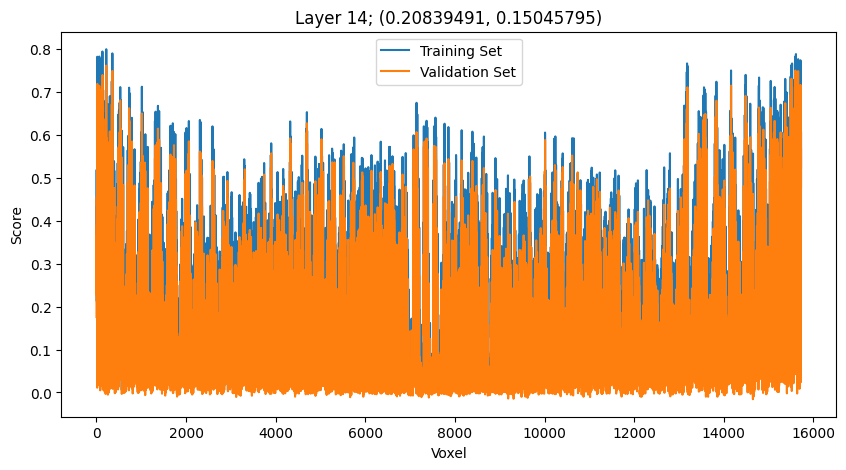

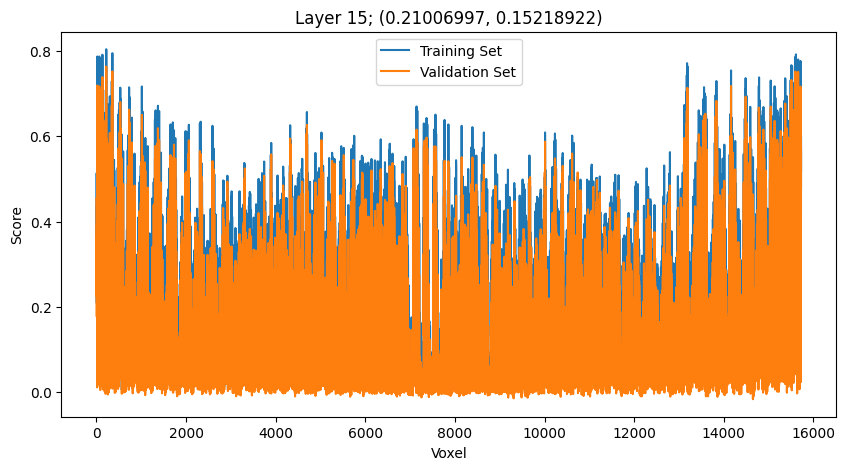

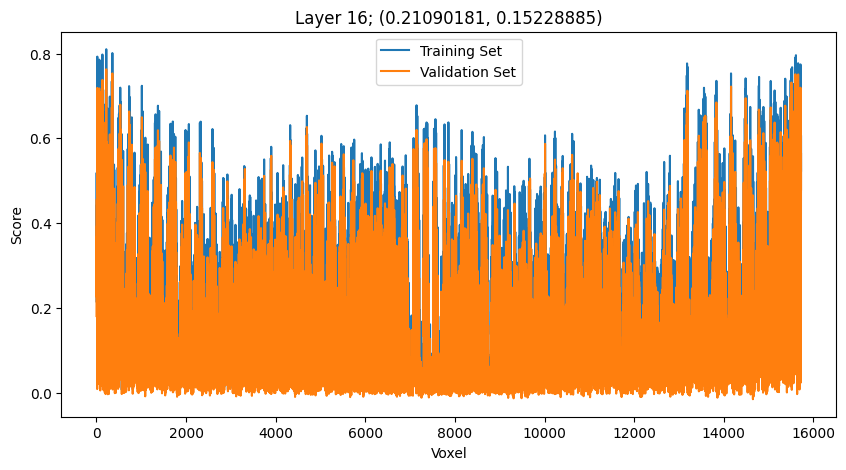

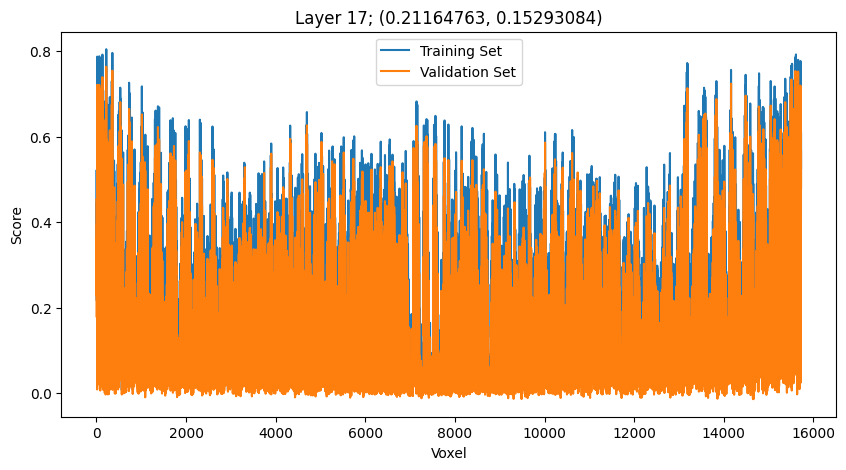

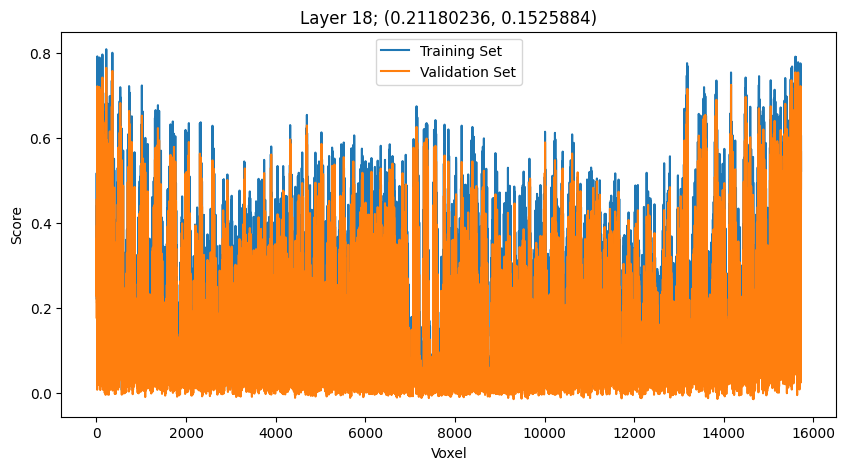

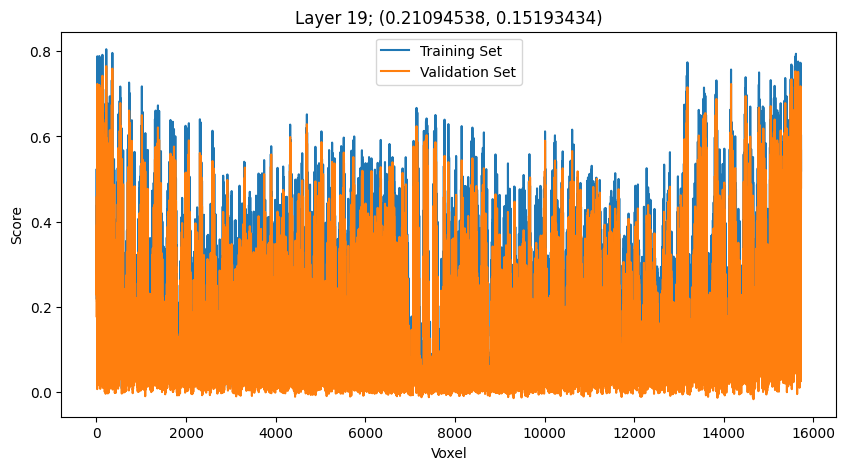

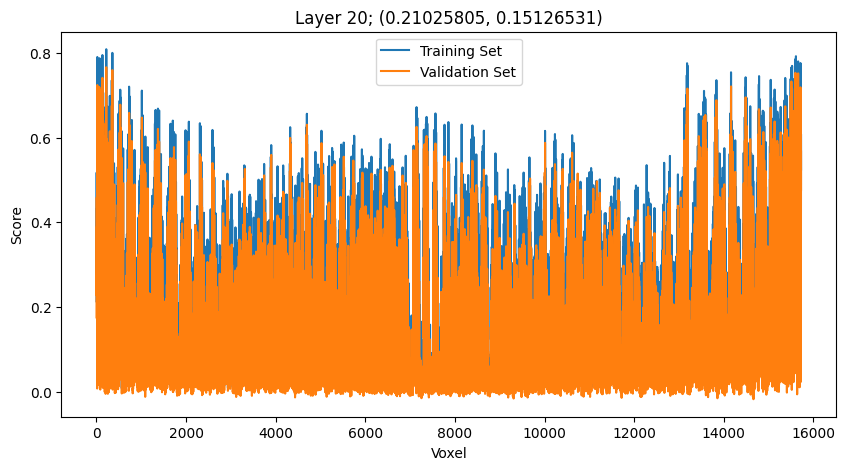

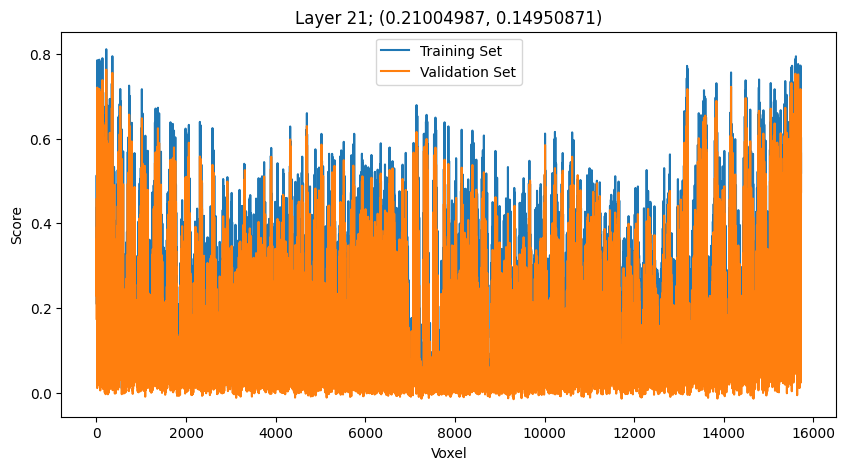

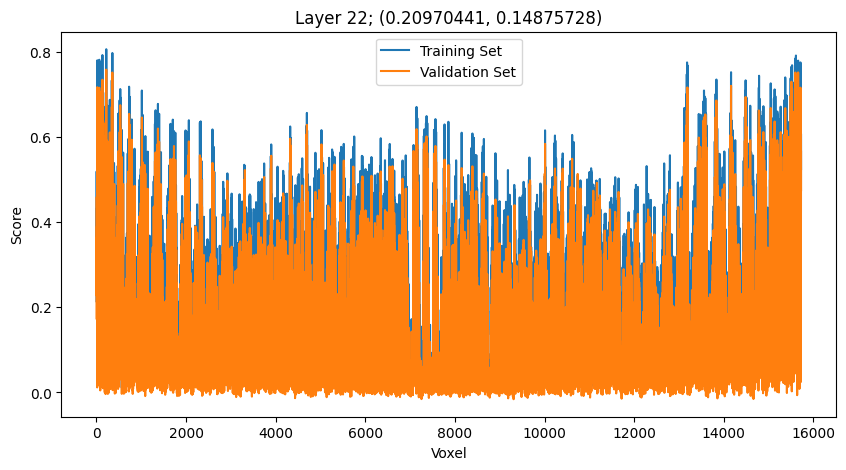

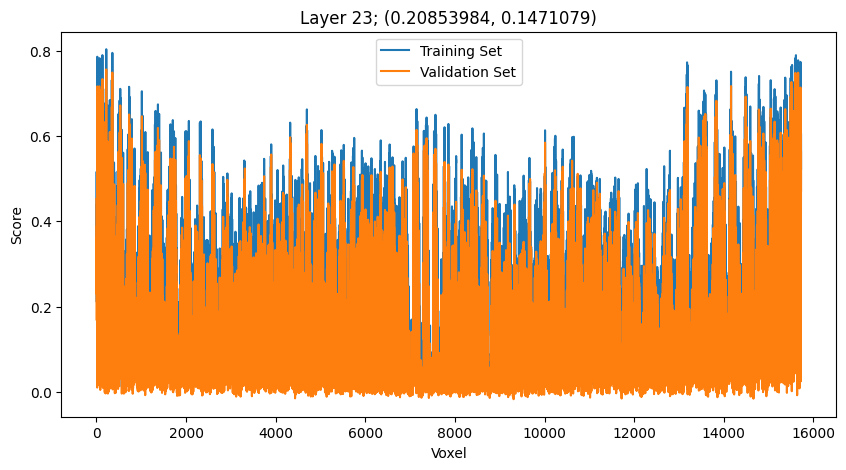

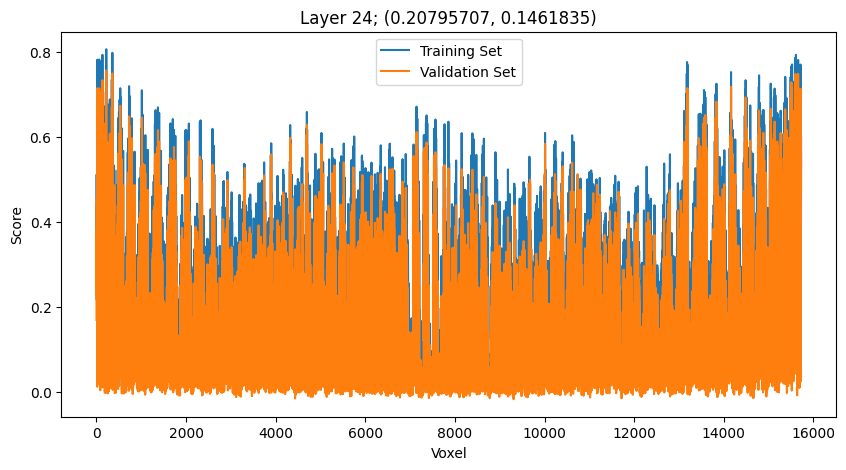

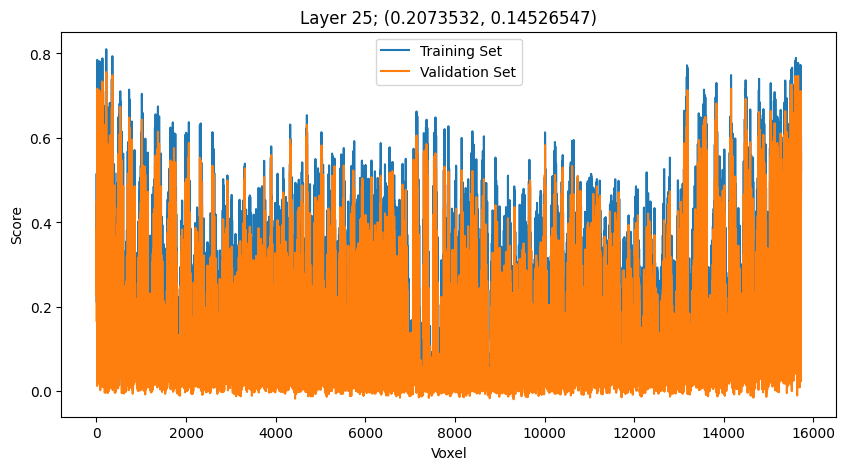

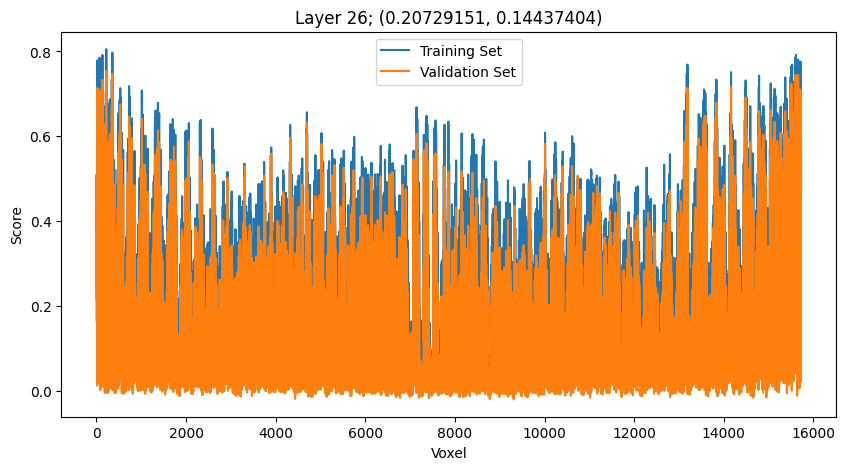

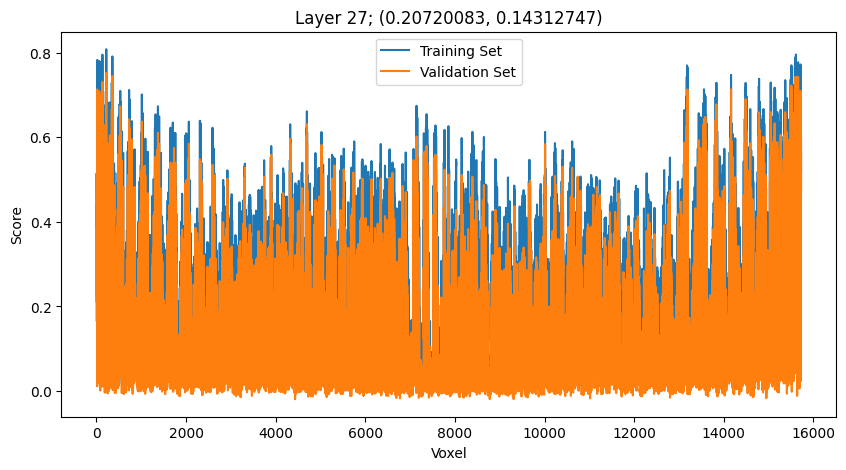

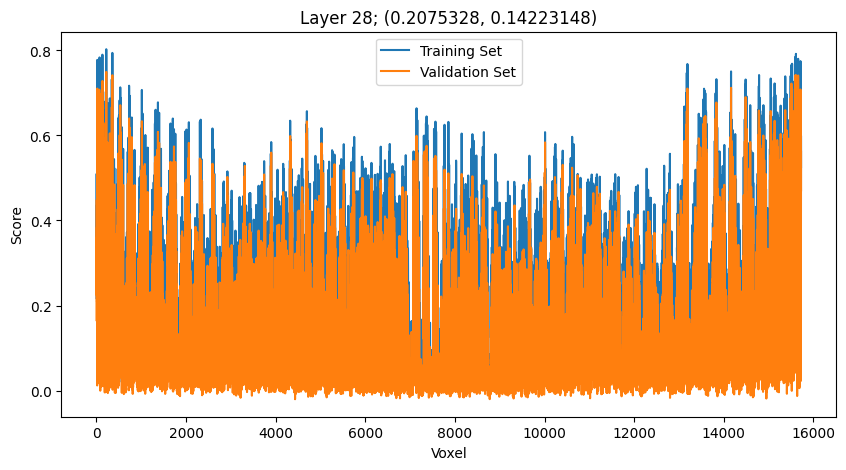

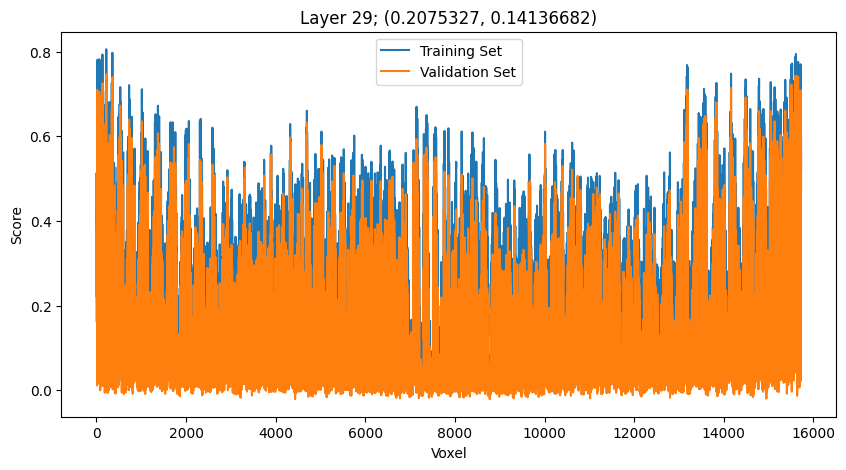

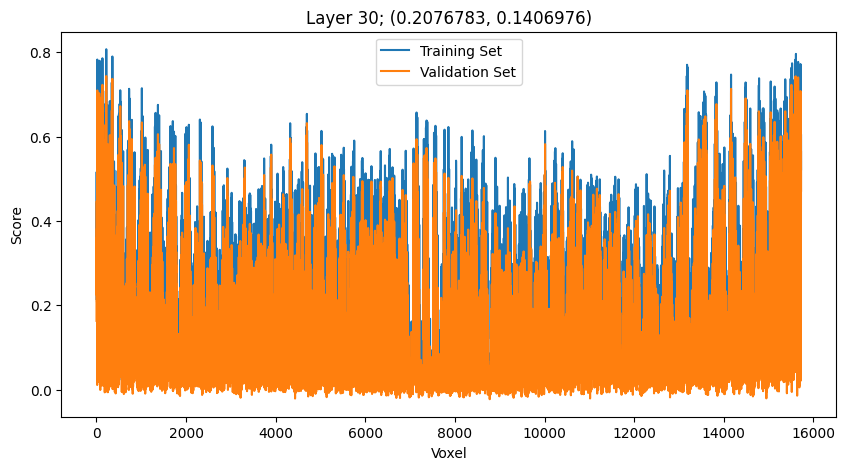

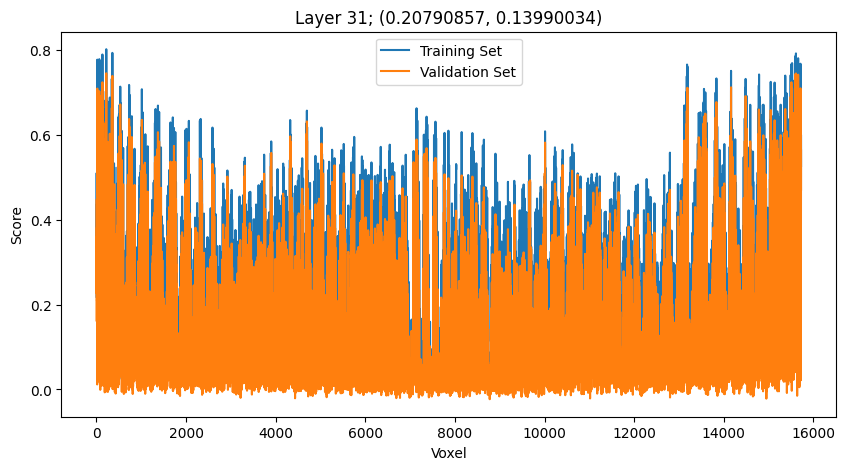

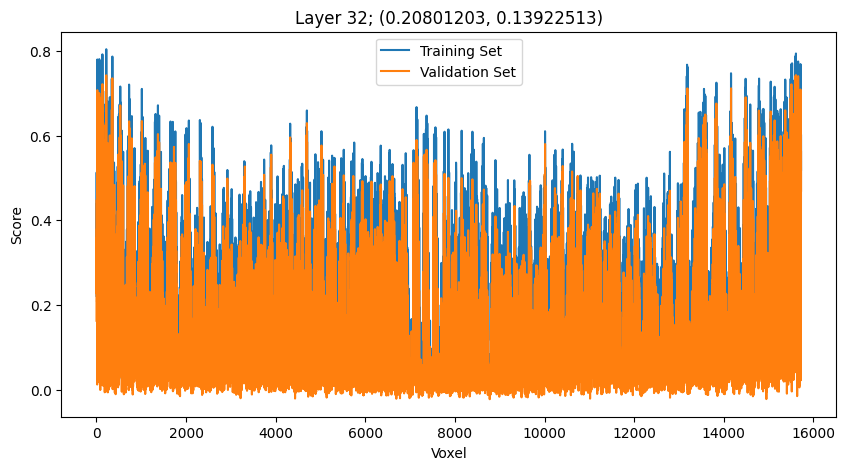

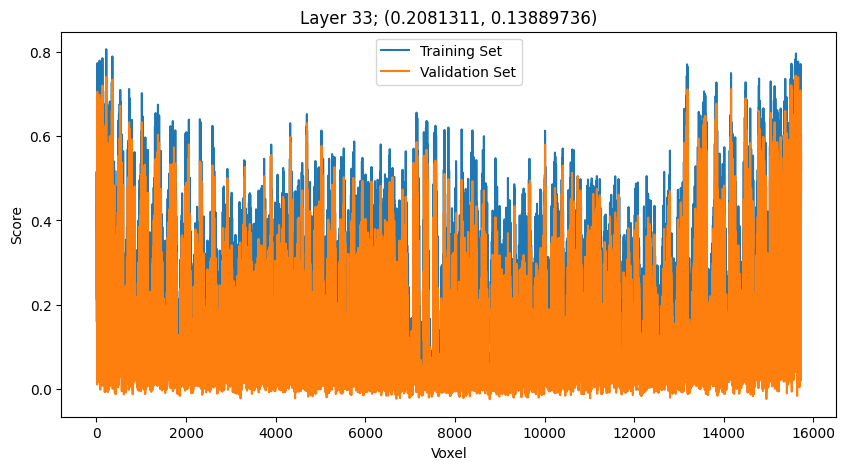

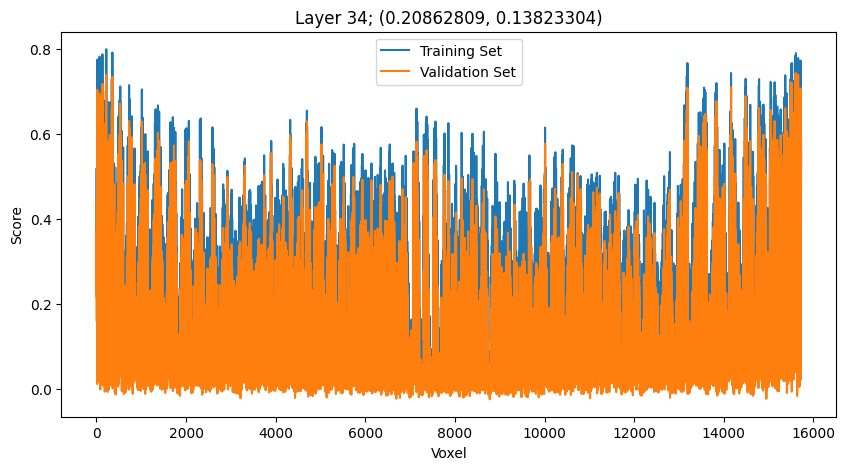

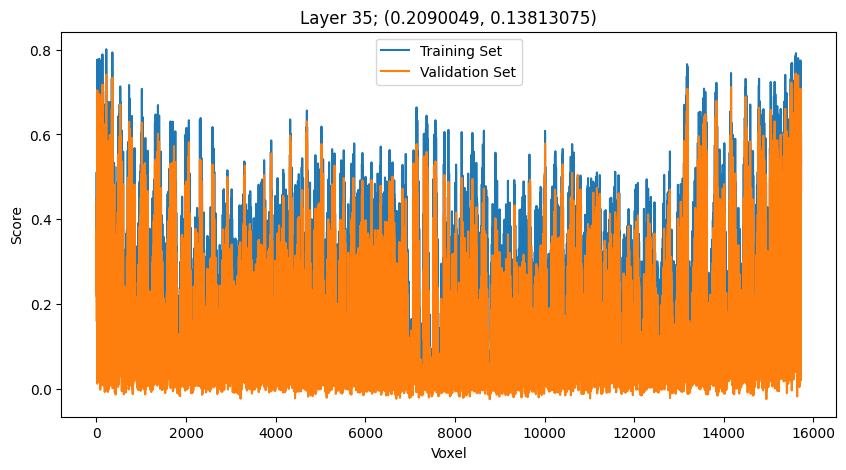

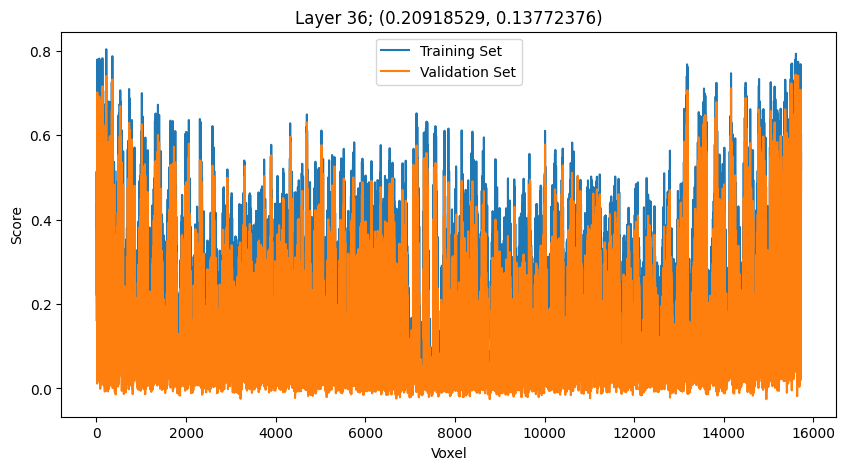

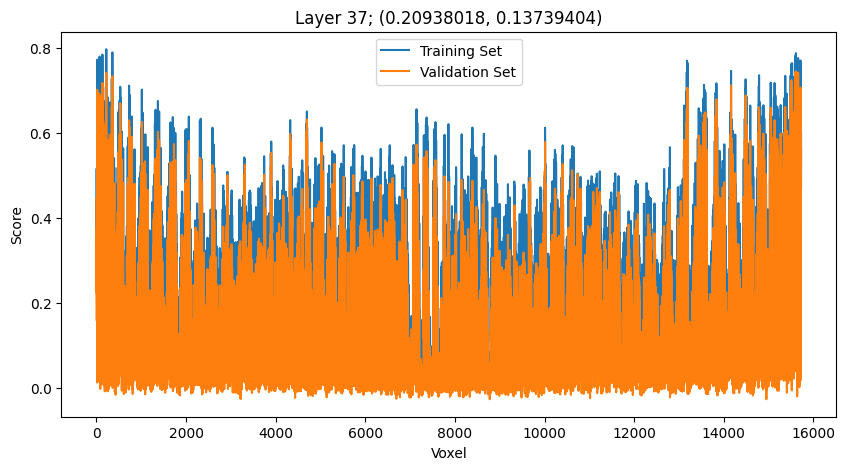

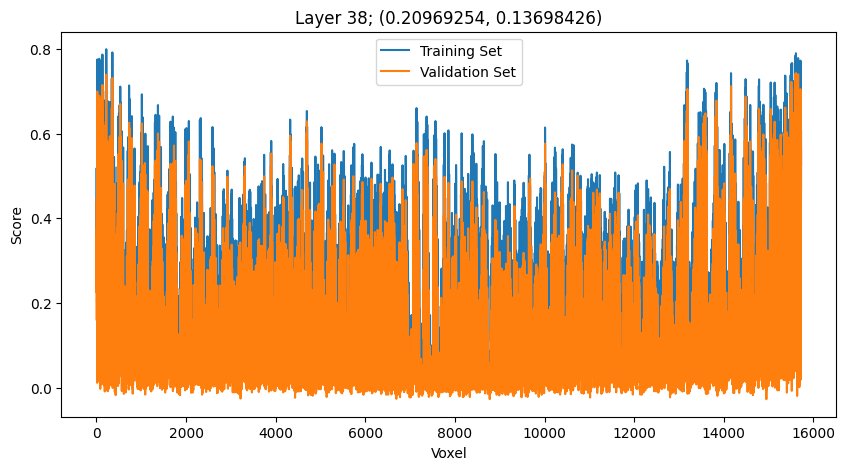

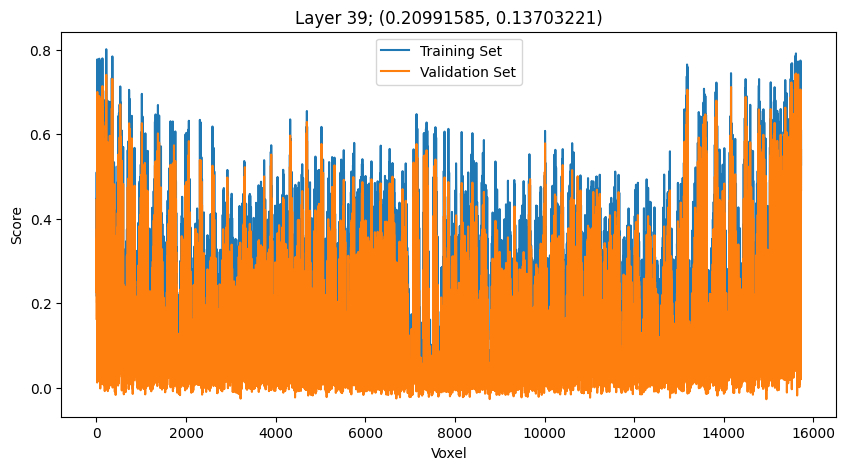

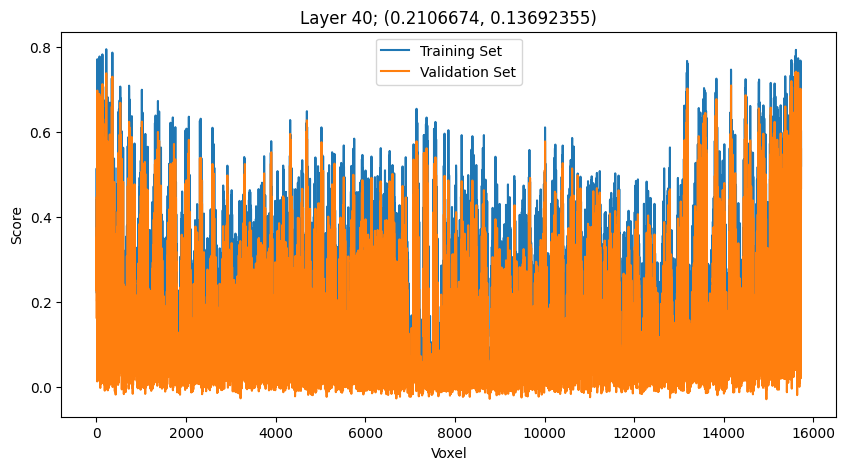

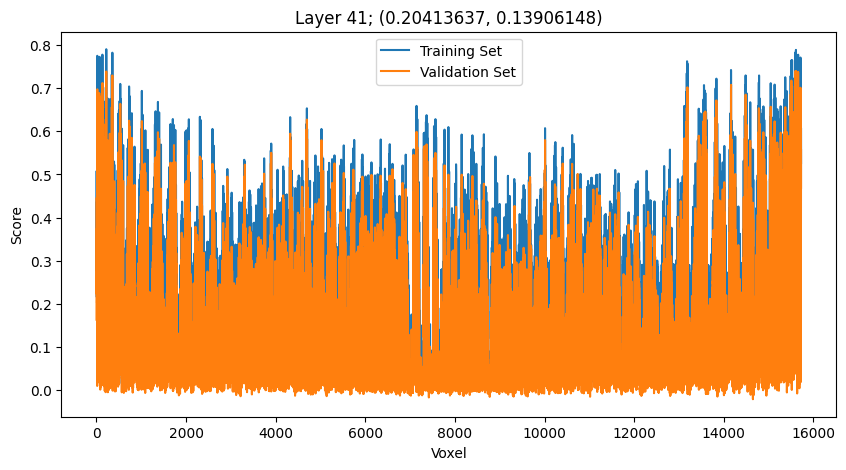

In [35]:
from matplotlib import pyplot as plt
import numpy as np
import os
from os import path

voxel_scores_output_dir = path.join(OUTPUT_DIR, "voxel_scores")

os.makedirs(voxel_scores_output_dir, exist_ok=True)

for model_num, model in enumerate(MODELS):
    num_voxels = model["trn_scores"].shape[0]
    x = np.array(range(1, num_voxels+1))

    plt.figure(figsize=(10, 5))
    plt.plot(x, model["trn_scores"], label="Training Set")
    plt.plot(x, model["val_scores"], label="Validation Set")
    plt.title(f"Layer {model_num+1:02}; {np.mean(model['trn_scores']), np.mean(model['val_scores'])}")
    plt.xlabel("Voxel")
    plt.ylabel("Score")
    plt.legend()
    plt.savefig(path.join(voxel_scores_output_dir, f"layer_{model_num+1:02}"))
    plt.show()